In [1]:
import os
import sys
from time import time
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import networkx as nx
import random

from keras import layers, models, optimizers
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.models import Model

from utils import combine_images
from utils import plot_log

from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
sys.path.append('./PatchyTools/')
from PatchyConverter import PatchyConverter
from ConvNetPatchy import ConvNetPatchy
from DropboxLoader import DropboxLoader
from CapsuleParameters import CapsuleParameters
from CapsuleParameters import CapsuleTrainingParameters
from GraphClassifier import GraphClassifier
from keras import backend as K


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data

In [2]:
# Getting the data:
dataset_name = 'MUTAG'
receptive_field = 10
relabeling = True
stride = 1

In [3]:
# Adjeceny dict and 
data_graph = PatchyConverter(dataset_name, receptive_field,stride)
# Converting Graphs into Matrices:
if relabeling:
    data_graph.relabel_graphs()

importing graph data
number of graphs in MUTAG dataset : 188
number of features : 7
Separating Graphs per graph ID
getting width
width: 18


In [4]:
graph_tensor = data_graph.graph_to_patchy_tensor_bc()

MUTAG tensor exists, loading it from Dropbox
Loading path: /Users/marcelogutierrez/.gamma_link/Samples/MUTAG/MUTAG_patchy_bc_tensor_w_18_relabelled.npy


In [5]:
nauty_tensor = data_graph.graphs_to_patchy_tensor()

MUTAG tensor exists, loading it from Dropbox
Loading path: /Users/marcelogutierrez/.gamma_link/Samples/MUTAG/MUTAG_patchy_bc_tensor_w_18_relabelled.npy


In [6]:
dropbox_loader = DropboxLoader(dataset_name)
graph_labels = dropbox_loader.get_graph_label()
graph_labels = np.array(graph_labels.graph_label)
n_class = len(np.unique(graph_labels))

In [7]:
# Capsule Architecture Parameters:
capsule_params= CapsuleParameters()

# First conv layer: 'filters', kernel_size)
conv_layer_name = 'conv_layer'
conv_layer_params = {}
conv_layer_params['filters'] = 256
conv_layer_params['kernel_size'] = 9
conv_layer_params['strides'] = [1, 1]
conv_layer_params['padding'] = 'VALID'
conv_layer_params['activation'] = 'relu'
conv_layer_params['name'] = 'conv1'

capsule_params.add_params(conv_layer_params,conv_layer_name)

# First Capsule Layer:
# [num_output_caps, caps_len,'filters',kernel_size,strides,padding]
caps_layer_name = 'caps_layer'
caps_layer_params = {}
caps_layer_params['filters'] = 256
caps_layer_params['kernel_size'] = 2
caps_layer_params['strides'] = [2,2]
caps_layer_params['padding'] = 'VALID'
caps_layer_params['padding'] = 'VALID'
caps_layer_params['n_channels'] = 32
caps_layer_params['dim_capsule'] = 8
caps_layer_params['name'] = 'caps_layer'
capsule_params.add_params(caps_layer_params,caps_layer_name)

# Digit Capsule Layer:
digit_layer_name = 'digitcaps_layer'
digit_layer_params = {}
digit_layer_params['n_channels'] = 10
digit_layer_params['dim_capsule'] = 16
digit_layer_params['name'] = 'digitcaps'
capsule_params.add_params(digit_layer_params,digit_layer_name )

# Capsule Decoder:
decoder_layer = 'decoder_layer'
decoder_params = {}
decoder_params['first_dense'] = 256 #250 #512
decoder_params['second_dense'] = 512
decoder_params['name'] = 'decoder'
capsule_params.add_params(decoder_params,decoder_layer)

# Training parameters:
parameter_set = CapsuleTrainingParameters()

In [8]:
# Training Graph Classifier:
x_train, x_test, y_train, y_test = train_test_split(graph_tensor,graph_labels,test_size=0.10,random_state=0)
data = ((x_train, y_train), (x_test, y_test))
input_shape = x_train.shape[1:]

patchy_classifier = GraphClassifier(input_shape,n_class)
patchy_classifier.build_the_graph(capsule_params)
##
#patchy_classifier.train_model.summary()

parameter_set.epochs = 200
patchy_classifier.train(data, parameter_set)
print('validation accuracy: {}'.format(patchy_classifier.results.val_capsnet_acc))

Instructions for updating:
dim is deprecated, use axis instead
time to generate the model: 0.7657179832458496
Trained model saved to './result/trained_model.h5'
validation accuracy: 0.8947368264198303


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
embedding_func = K.function([patchy_classifier.eval_model.input], [patchy_classifier.primarycaps])
x_eval = graph_tensor
y_eval = graph_labels
node_embeddings=embedding_func([x_eval])[0]
print(node_embeddings[0].shape)
X = node_embeddings.reshape(node_embeddings.shape[0],-1)
print(X.shape)

(160, 8)
(188, 1280)


In [10]:
df = pd.read_csv(patchy_classifier.log_file)  # ,index_col=0)
#df = df.loc[:, ['epoch', 'capsnet_acc', 'val_capsnet_acc']]
#results = df.iloc[-1, :]  # .val_capsnet_acc
#df.head(15)

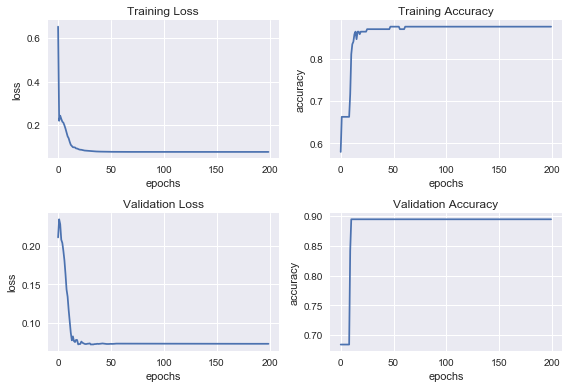

validation accuracy: 0.8947368264198303


In [11]:
# Multiplots

plt.subplot(2,2,1)
plt.plot(df.capsnet_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')

plt.subplot(2,2,2)
plt.plot(df.capsnet_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training Accuracy')

plt.subplot(2,2,3)
plt.plot(df.val_capsnet_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Validation Loss')


plt.subplot(2,2,4)
plt.plot(df.val_capsnet_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.tight_layout()


plt.show()
print('validation accuracy: {}'.format(patchy_classifier.results.val_capsnet_acc))

In [12]:
perplexity = 20
embedding = TSNE(n_components=2,perplexity=perplexity,random_state = 0)
X_r = embedding.fit_transform(X)
target_ids = np.unique(graph_labels)
target_names = ['neg', 'pos']

embedding = TSNE(n_components=2,perplexity=perplexity,random_state = 0)
X_patchy = graph_tensor.reshape(graph_tensor.shape[0],-1)
X_rp = embedding.fit_transform(X_patchy)

In [13]:
# Getting the embeddings:
#embedding_func = K.function([patchy_classifier.eval_model.input], [patchy_classifier.conv1])
#node_embeddings = embedding_func([x_train])

# embedding_func = K.function([patchy_classifier.eval_model.input], [patchy_classifier.graphcaps])
# node_embeddings = embedding_func([x_train])[0]


# embedding_func = K.function([patchy_classifier.eval_model.input], [patchy_classifier.primarycaps])
# x_eval = graph_tensor
# y_eval = graph_labels
# node_embeddings=embedding_func([x_eval])[0]
# print(node_embeddings[0].shape)
# X = node_embeddings.reshape(node_embeddings.shape[0],-1)
# print(X.shape)

In [14]:
j = 0
epochs = 200
patchy_cnn = ConvNetPatchy(graph_tensor, graph_labels)
patchy_cnn.split_data(random_state=j)
patchy_cnn.build_graph()
patchy_cnn.train_model(epochs=epochs)
print('Fold {} completed with val acc : {}'.format(j, patchy_cnn.final_val_acc))

intermediate_layer = Model(input=patchy_cnn.model.input, output= patchy_cnn.model.get_layer(index=3).output)
X_cnn = intermediate_layer.predict(graph_tensor)
X_cnn = X_cnn.reshape(X_cnn.shape[0],-1)


Fold 0 completed with val acc : 0.7894737124443054


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [15]:
embedding = TSNE(n_components=2,perplexity=perplexity,random_state = 0)
X_cnn_emb = embedding.fit_transform(X_cnn)

In [16]:
embedding = TSNE(n_components=2,perplexity=perplexity, random_state = 0)
X_nauty = embedding.fit_transform(nauty_tensor.reshape(nauty_tensor.shape[0],-1))

Text(0.5, 1.0, 't-sne from patchy representations')

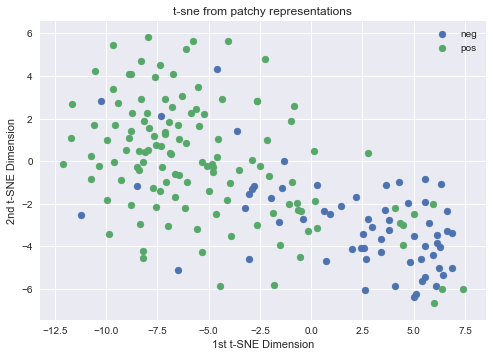

In [17]:
for i, label in zip(target_ids, target_names):
    plt.scatter(X_nauty[y_eval== i][:,0],X_nauty[y_eval== i][:,1], label=label)

plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from patchy representations')


Text(0.5, 1.0, 't-sne from patchy representations')

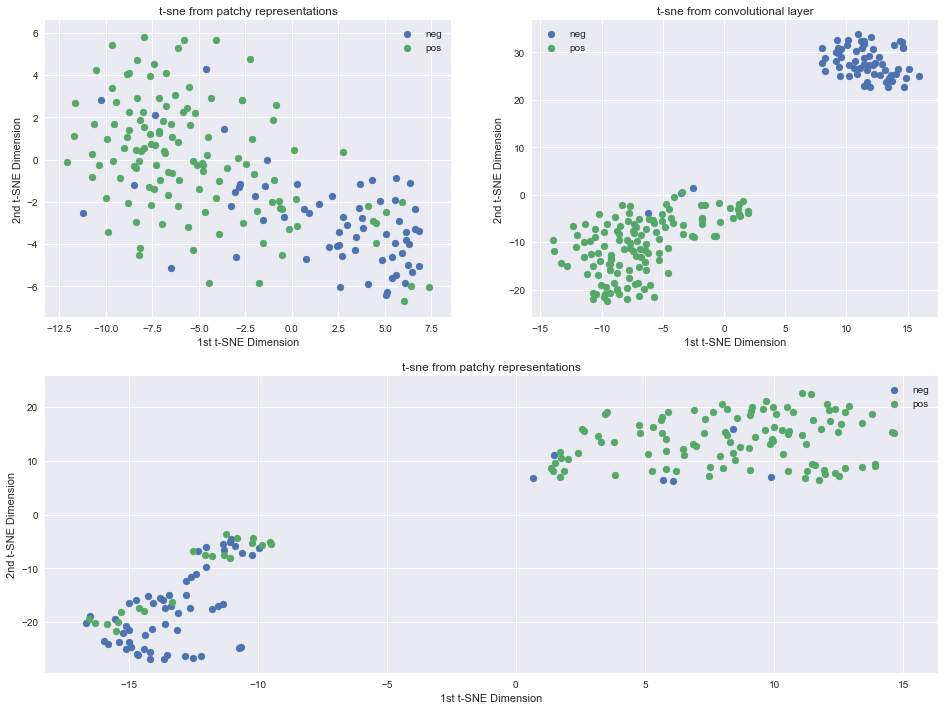

In [19]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(16,12))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
#ax.set_axis_off()
for i, label in zip(target_ids, target_names):
    plt.scatter(X_rp[y_eval== i][:,0],X_rp[y_eval== i][:,1], label=label)

plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from patchy representations')


ax = plt.subplot(gs[0, 1]) # row 1, span all columns
for i, label in zip(target_ids, target_names):
    plt.scatter(X_cnn_emb[y_eval== i][:,0],X_cnn_emb[y_eval== i][:,1], label=label)

plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from convolutional layer')

ax = plt.subplot(gs[1, :]) # row 0, col 1
for i, label in zip(target_ids, target_names):
    plt.scatter(X_r[y_eval== i][:,0],X_r[y_eval== i][:,1], label=label)
plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from patchy representations')





In [20]:
DIR_PATH = os.environ['GAMMA_DATA_ROOT']
for X_to_df,model_name in zip([X_r, X_rp,X_cnn_emb],['caps','patchy','cnn']):
    folder_name = '{}_{}_tsne.csv'.format(dataset_name,model_name)
    path_name = os.path.join(DIR_PATH+'/Results/CapsuleSans/TSNE',folder_name)
    df = pd.DataFrame(np.c_[X_to_df, y_eval], columns=['comp_1','comp_2','label'])
    df.to_csv(path_name)


In [ ]:
# # Training Graph Classifier:
# x_train, x_test, y_train, y_test = train_test_split(graph_tensor,graph_labels,test_size=0.10,random_state=0)
# data = ((x_train, y_train), (x_test, y_test))
# input_shape = x_train.shape[1:]

# patchy_classifier = GraphClassifier(input_shape,n_class)
# patchy_classifier.build_the_graph(capsule_params)
# ##
# #patchy_classifier.train_model.summary()

# parameter_set.epochs = 200
# patchy_classifier.train(data, parameter_set)
# print('validation accuracy: {}'.format(patchy_classifier.results.val_capsnet_acc))

In [ ]:
# Intra-cluster distance 
mse_caps = 0
mean_patchy =0
mse_cnn = 0
for i in target_ids:
    mean_point = np.tile(X_r[y_eval== i].mean(0),(X_r[y_eval== i].shape[0],1))
    mse_caps += mean_squared_error(X_r[y_eval== i],mean_point)
print(mse_caps)

for i in target_ids:
    mean_point = np.tile(X_rp[y_eval== i].mean(0),(X_rp[y_eval== i].shape[0],1))
    mse_patchy += mean_squared_error(X_rp[y_eval== i],mean_point)
print(mse_patchy)

for i in target_ids:
    mean_point = np.tile(X_cnn_emb[y_eval== i].mean(0),(X_cnn_emb[y_eval== i].shape[0],1))
    mse_cnn += mean_squared_error(X_cnn_emb[y_eval== i],mean_point)
print(mse_cnn)

In [ ]:
# Inter-cluster distance
mean_point1 = X_r[y_eval== target_ids[0]].mean(0)
mean_point2 = X_r[y_eval== target_ids[1]].mean(0)
dist_caps = mean_squared_error(mean_point1,mean_point2)
print(dist_caps)

mean_point1 = X_rp[y_eval== target_ids[0]].mean(0)
mean_point2 = X_rp[y_eval== target_ids[1]].mean(0)
dist_patchy = mean_squared_error(mean_point1,mean_point2)
print(dist_patchy)
mean_point1 = X_cnn_emb[y_eval== target_ids[0]].mean(0)
mean_point2 = X_cnn_emb[y_eval== target_ids[1]].mean(0)
dist_cnn = mean_squared_error(mean_point1,mean_point2)
print(dist_cnn)

In [ ]:
mean_point = np.tile(X_cnn_emb[y_eval== i].mean(0),(X_cnn_emb[y_eval== i].shape[0],1))
mean_squared_error(X_cnn_emb[y_eval== i],mean_point)

## PCA

In [ ]:
# PCA:
pca = PCA(n_components=2)
pca.fit(X)


print('explained variance ratio: {}'.format(pca.explained_variance_ratio_))
print('Singular values : {}'.format(pca.singular_values_)  )
target_ids = np.unique(graph_labels)
target_names = ['neg', 'pos']
plt.figure(figsize=(6, 5))
for i, label in zip(target_ids, target_names):
    plt.scatter(X_r[y_eval== i][:,0],X_r[y_eval== i][:,1], label=label)
    plt.xlabel('1st PCA Dimension')
    plt.ylabel('2nd PCA Dimension')
plt.legend()
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(16,12))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
#ax.set_axis_off()
for i, label in zip(target_ids, target_names):
    plt.scatter(X_rp[y_eval== i][:,0],X_rp[y_eval== i][:,1], label=label)

plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from patchy representations')


ax = plt.subplot(gs[0, 1]) # row 1, span all columns
for i, label in zip(target_ids, target_names):
    plt.scatter(X_cnn_emb[y_eval== i][:,0],X_cnn_emb[y_eval== i][:,1], label=label)

plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from convolutional layer')

ax = plt.subplot(gs[1, :]) # row 0, col 1
for i, label in zip(target_ids, target_names):
    plt.scatter(X_r[y_eval== i][:,0],X_r[y_eval== i][:,1], label=label)
plt.xlabel('1st t-SNE Dimension')
plt.ylabel('2nd t-SNE Dimension')
plt.legend()
plt.title('t-sne from patchy representations')





### Testing with SVM

In [ ]:


# acc_list = []
# for j in range(10):
#     x_train, x_test, y_train, y_test = train_test_split(graph_tensor,graph_labels,test_size=0.10,random_state=j)
#     #data = ((x_train, y_train), (x_test, y_test))
#     #input_shape = x_train.shape[1:]
#     X = x_train.reshape(x_train.shape[0],-1)
#     y = y_train.reshape(y_train.shape[0],-1)
#     clf = svm.SVC()
#     clf.fit(X, y)  
#     X_test_svm = x_test.reshape(x_test.shape[0],-1)
#     y_test_svm = y_test.reshape(y_test.shape[0],-1)
#     y_pred = clf.predict(X_test_svm)
#     acc = accuracy_score(y_pred,y_test_svm)
#     acc_list.append(acc)
#     print(acc)
# print('mean acc : {}'.format(np.mean(acc_list)))
# print('std acc : {}'.format(np.std(acc_list)))
    

In [ ]:
# patchy_classifier = GraphClassifier(input_shape,6)
# patchy_classifier.build_the_graph(capsule_params)
# patchy_classifier.train(data, parameter_set)
#patchy_classifier.train_model.summary()